# Hydrogel Controlled Release Fertilizer Simulation

This notebook implements a numerical simulation of nutrient diffusion from a semi-spherical hydrogel fertilizer in water. It models the diffusion process using a 2D grid in cylindrical coordinates with radial symmetry and visualizes the concentration changes over time.

## 1. Setup and Imports

First, we import the necessary libraries for numerical operations, visualization, and animation.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import time
import scipy.stats as stats

# Set plotting style
plt.style.use('ggplot')
%matplotlib inline

## 2. Define Model Parameters

We'll define all the parameters needed for our simulation, including:
- Semi-spherical geometry dimensions
- Diffusion coefficient
- Grid dimensions
- Simulation time and time steps
- Initial concentration setup (can be adjusted as needed)
- Volumes for hydrogel and water

In [26]:
# Hydrogel geometry parameters
# Circumference = 1.1 cm, so radius = 1.1 / (2*π) ≈ 0.175 cm
radius = 0.175  # cm
height = 0.9   # cm

# Initial concentration of nutrient in the hydrogel
initial_concentration = 10.0  # dimensionless units, can be adjusted as needed

# Diffusion coefficient
D = 1e-8  # cm²/s

# Grid parameters
nr = 50  # number of radial points
nz = 30  # number of axial points

# Create the grid
r = np.linspace(0, radius*2, nr)  # extend beyond the hydrogel
z = np.linspace(0, height*1.5, nz)  # extend beyond the hydrogel
dr = r[1] - r[0]
dz = z[1] - z[0]

# Time parameters
total_days = 7
total_time = total_days * 24 * 60 * 60  # 7 days in seconds
nt = 10000  # number of time steps
dt = total_time / nt  # time step size

# Setup grid matrices
R, Z = np.meshgrid(r, z)

# Initialize concentration array (2D grid with cylindrical symmetry)
C = np.zeros((nz, nr))

# Fill the semi-sphere with initial concentration
for i in range(nz):
    for j in range(nr):
        # Check if point is inside the semi-spherical hydrogel
        if r[j]**2 + z[i]**2 <= radius**2 and z[i] <= height:
            C[i, j] = initial_concentration  # initial concentration inside hydrogel

# Calculate hydrogel volume by summing all cell volumes within the semi-sphere
hydrogel_volume_ml = 0
for i in range(nz):
    for j in range(nr):
        if r[j]**2 + z[i]**2 <= radius**2 and z[i] <= height:
            # Cell volume in cylindrical coordinates: 2π * r * dr * dz (for full circle)
            # For our 2D grid with radial symmetry, we use π * ((r+dr/2)² - (r-dr/2)²) * dz
            # Simplified to π * 2r * dr * dz
            cell_volume = np.pi * 2 * r[j] * dr * dz
            hydrogel_volume_ml += cell_volume

hydrogel_volume_ml /= 1000  # convert from cm³ to ml

# Water volume (surrounding medium)
water_volume_ml = 100  # ml

# Initial amount of nutrient in hydrogel
initial_nutrient_amount = initial_concentration * hydrogel_volume_ml  # concentration * volume

print(f"Hydrogel radius: {radius:.3f} cm")
print(f"Hydrogel height: {height:.3f} cm")
print(f"Initial concentration: {initial_concentration:.2f} units")
print(f"Hydrogel volume: {hydrogel_volume_ml:.6f} ml")
print(f"Water volume: {water_volume_ml:.1f} ml")
print(f"Time step: {dt:.2f} seconds")
print(f"Grid size: {nr} radial points x {nz} axial points")
print(f"Initial nutrient amount: {initial_nutrient_amount:.6f} units")

Hydrogel radius: 0.175 cm
Hydrogel height: 0.900 cm
Initial concentration: 10.00 units
Hydrogel volume: 0.000013 ml
Water volume: 100.0 ml
Time step: 60.48 seconds
Grid size: 50 radial points x 30 axial points
Initial nutrient amount: 0.000133 units


## 3. Implement Diffusion Model

We'll implement the 2D diffusion equation in cylindrical coordinates with radial symmetry:

∂C/∂t = D(∂²C/∂r² + (1/r)(∂C/∂r) + ∂²C/∂z²)

We'll use the finite difference method to solve this equation numerically, applying appropriate boundary conditions and tracking mass conservation.

In [27]:
# Create a mask to identify the hydrogel region
hydrogel_mask = np.zeros((nz, nr), dtype=bool)
for i in range(nz):
    for j in range(nr):
        if r[j]**2 + z[i]**2 <= radius**2 and z[i] <= height:
            hydrogel_mask[i, j] = True

# Initialize arrays to store concentration history and release data
sample_times = np.linspace(0, total_time, 100)
saved_time_indices = [int(t / total_time * nt) for t in sample_times]
saved_time_indices = [min(idx, nt-1) for idx in saved_time_indices]

C_history = np.zeros((len(saved_time_indices), nz, nr))
release_percentage = np.zeros(len(saved_time_indices))
time_points = np.zeros(len(saved_time_indices))

# Arrays for time series data
all_time_points = []
all_release_percentages = []

# Function to calculate nutrient amount in hydrogel and water
def calculate_nutrient_amounts(C):
    # Calculate amount in hydrogel
    hydrogel_amount = 0
    for i in range(nz):
        for j in range(nr):
            if hydrogel_mask[i, j]:
                cell_volume = np.pi * 2 * r[j] * dr * dz
                hydrogel_amount += C[i, j] * cell_volume
    
    hydrogel_amount /= 1000  # convert to ml
    
    # Amount in water is what has been released from the hydrogel
    water_amount = initial_nutrient_amount - hydrogel_amount
    
    # Water concentration
    water_concentration = water_amount / water_volume_ml
    
    return hydrogel_amount, water_amount, water_concentration

# Run the simulation
print("Starting simulation...")
start_time = time.time()

# Initialize water concentration
_, _, water_concentration = calculate_nutrient_amounts(C)

# Store initial state
C_history[0] = C.copy()
hydrogel_amount, water_amount, _ = calculate_nutrient_amounts(C)
release_percentage[0] = (water_amount / initial_nutrient_amount) * 100
time_points[0] = 0

all_time_points.append(0)
all_release_percentages.append(release_percentage[0])

# Convergence criteria
equilibrium_threshold = 1e-6  # threshold for detecting equilibrium
last_release = release_percentage[0]

# Time stepping
history_idx = 1
for n in range(1, nt):
    # Create a copy for updating
    C_new = C.copy()
    
    # Update water concentration
    _, _, water_concentration = calculate_nutrient_amounts(C)
    
    # Apply finite difference update inside the hydrogel
    for i in range(1, nz-1):
        for j in range(1, nr-1):  # Skip j=0 (center axis) for now
            if hydrogel_mask[i, j]:
                # Finite difference for r (cylindrical coordinates)
                d2C_dr2 = (C[i, j+1] - 2*C[i, j] + C[i, j-1]) / (dr**2)
                dC_dr = (C[i, j+1] - C[i, j-1]) / (2*dr)
                
                # Finite difference for z
                d2C_dz2 = (C[i+1, j] - 2*C[i, j] + C[i-1, j]) / (dz**2)
                
                # Update using the diffusion equation: dC/dt = D(d2C/dr2 + (1/r)(dC/dr) + d2C/dz2)
                # Only allow diffusion out of hydrogel if C > water_concentration
                if C[i, j] > water_concentration:
                    # Apply the full diffusion equation
                    C_new[i, j] = C[i, j] + dt * D * (d2C_dr2 + (1/r[j])*dC_dr + d2C_dz2)
                else:
                    # Don't allow diffusion back into hydrogel
                    C_new[i, j] = max(C[i, j], water_concentration)
    
    # Special case for center axis (r=0) - use symmetry condition
    # At r=0, dC/dr = 0 and the term (1/r)(dC/dr) becomes d2C/dr2
    for i in range(1, nz-1):
        if hydrogel_mask[i, 0]:
            # Use symmetry to get d2C/dr2 at r=0
            # We can use the formula: d2C/dr2 = 2(C[i,1] - C[i,0])/dr^2
            d2C_dr2 = 2 * (C[i, 1] - C[i, 0]) / (dr**2)
            
            # Finite difference for z
            d2C_dz2 = (C[i+1, 0] - 2*C[i, 0] + C[i-1, 0]) / (dz**2)
            
            # Update using the diffusion equation
            if C[i, 0] > water_concentration:
                C_new[i, 0] = C[i, 0] + dt * D * (d2C_dr2 + d2C_dz2)
            else:
                C_new[i, 0] = max(C[i, 0], water_concentration)
    
    # Apply boundary conditions at edges
    # Set all values outside the hydrogel to the water concentration
    for i in range(nz):
        for j in range(nr):
            if not hydrogel_mask[i, j]:
                C_new[i, j] = water_concentration
    
    # Update concentration array
    C = C_new
    
    # Calculate current release percentage
    hydrogel_amount, water_amount, _ = calculate_nutrient_amounts(C)
    current_release = (water_amount / initial_nutrient_amount) * 100
    
    # Store data for all time points
    all_time_points.append(n * dt)
    all_release_percentages.append(current_release)
    
    # Store data at sample times
    if n in saved_time_indices:
        idx = saved_time_indices.index(n)
        C_history[idx] = C.copy()
        release_percentage[idx] = current_release
        time_points[idx] = n * dt
        history_idx += 1
    
    # Check for equilibrium
    if n % 100 == 0:
        release_change = abs(current_release - last_release)
        last_release = current_release
        
        if n % 1000 == 0:
            hours = (n * dt) / 3600
            print(f"Time: {hours:.2f} hours, Release: {current_release:.2f}%, Change: {release_change:.6f}%")
        
        if release_change < equilibrium_threshold:
            print(f"Equilibrium reached at step {n} ({n*dt/3600:.2f} hours)")
            
            # Fill the remaining history with the final state
            for i in range(history_idx, len(saved_time_indices)):
                C_history[i] = C.copy()
                release_percentage[i] = current_release
                time_points[i] = saved_time_indices[i] * dt
            
            break

end_time = time.time()
print(f"Simulation completed in {end_time - start_time:.2f} seconds")

# Convert time points to hours for easier display
time_hours = np.array(all_time_points) / 3600
time_days = np.array(all_time_points) / (24 * 3600)

# Convert sample times to days
sample_time_days = time_points / (24 * 3600)

Starting simulation...
Time: 16.80 hours, Release: 23.94%, Change: 1.229646%
Time: 16.80 hours, Release: 23.94%, Change: 1.229646%
Time: 33.60 hours, Release: 32.68%, Change: 0.669207%
Time: 50.40 hours, Release: 37.89%, Change: 0.422337%
Time: 33.60 hours, Release: 32.68%, Change: 0.669207%
Time: 50.40 hours, Release: 37.89%, Change: 0.422337%
Time: 67.20 hours, Release: 41.28%, Change: 0.281912%
Time: 67.20 hours, Release: 41.28%, Change: 0.281912%
Time: 84.00 hours, Release: 43.58%, Change: 0.193202%
Time: 100.80 hours, Release: 45.17%, Change: 0.134169%
Time: 117.60 hours, Release: 46.28%, Change: 0.093804%
Time: 134.40 hours, Release: 47.06%, Change: 0.065809%
Time: 151.20 hours, Release: 47.60%, Change: 0.046250%
Simulation completed in 9.34 seconds
Time: 84.00 hours, Release: 43.58%, Change: 0.193202%
Time: 100.80 hours, Release: 45.17%, Change: 0.134169%
Time: 117.60 hours, Release: 46.28%, Change: 0.093804%
Time: 134.40 hours, Release: 47.06%, Change: 0.065809%
Time: 151.20 ho

## 4. Create Visualizations

Let's create several visualizations to help understand the diffusion process and results:
1. 2D plots showing concentration at different time points
2. 3D visualization of the concentration profile
3. Animation of concentration changes over time
4. Plot of cumulative nutrient release percentage versus time

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

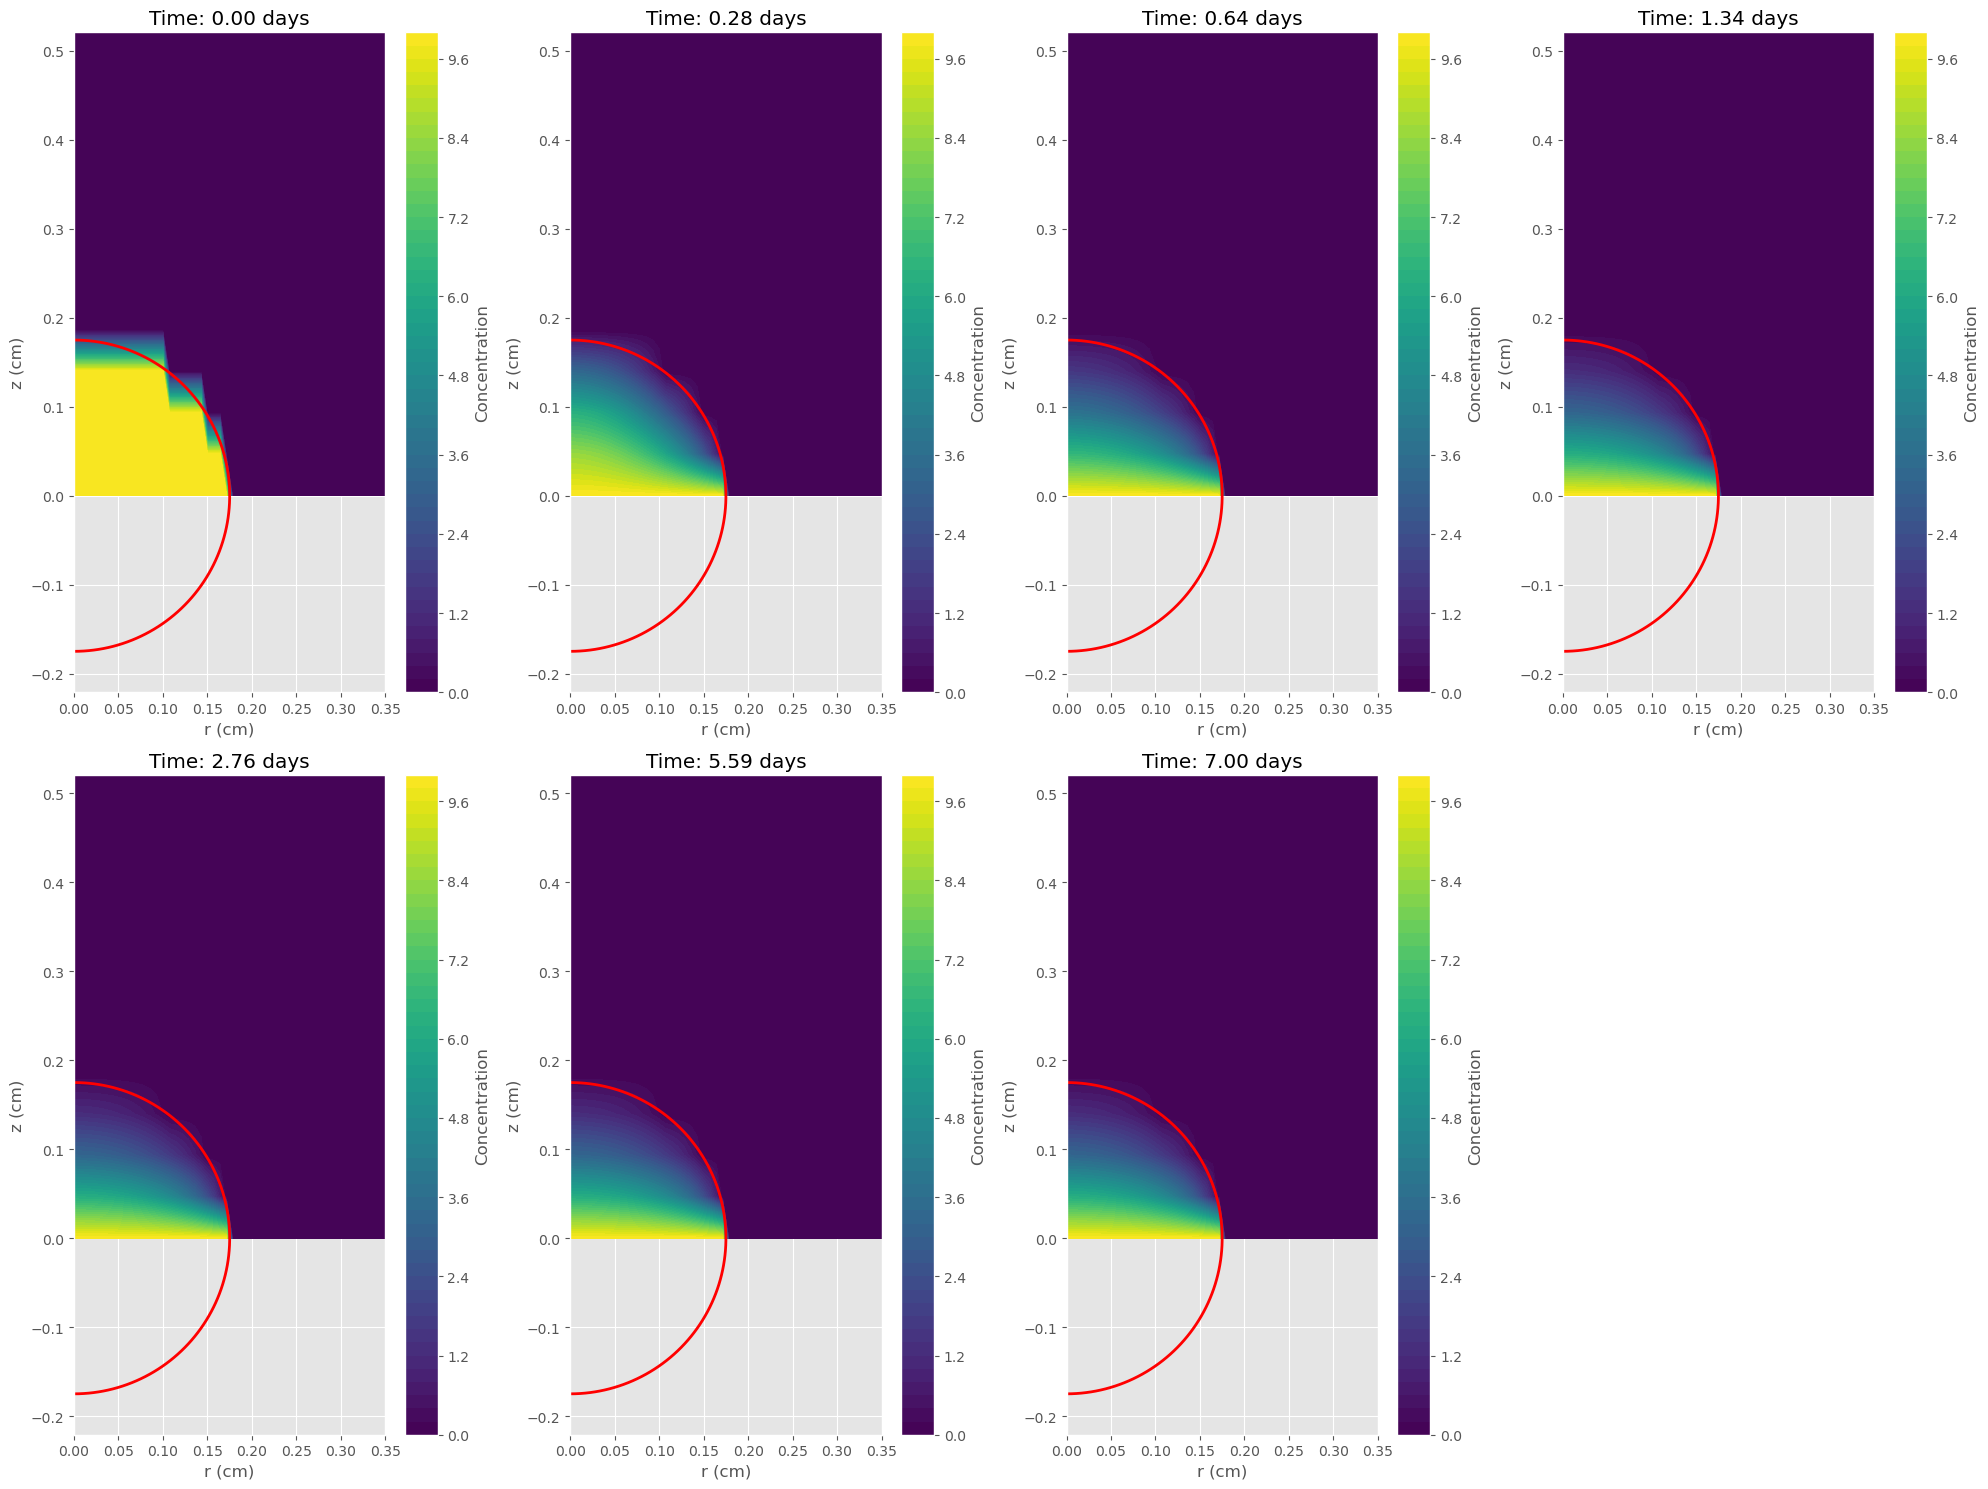

In [23]:
# 1. 2D plots showing concentration at different time points
plt.figure(figsize=(20, 15))
times_to_plot = [0, 4, 9, 19, 39, 79, 99]  # Indices corresponding to different times

for i, idx in enumerate(times_to_plot):
    plt.subplot(2, 4, i+1)
    
    # Create 2D visualization with contour plot
    contour = plt.contourf(R, Z, C_history[idx], levels=50, cmap='viridis')
    plt.colorbar(contour, label='Concentration')
    
    # Plot the hydrogel boundary
    theta = np.linspace(0, np.pi, 100)
    x_circle = radius * np.sin(theta)
    y_circle = radius * np.cos(theta)
    plt.plot(x_circle, y_circle, 'r-', linewidth=2)
    
    # Add straight line at z=height if height < radius
    if height < radius:
        plt.plot([-radius, radius], [height, height], 'r-', linewidth=2)
    
    plt.title(f"Time: {sample_time_days[idx]:.2f} days")
    plt.xlabel('r (cm)')
    plt.ylabel('z (cm)')
    plt.axis('equal')
    plt.xlim(0, radius*2)
    plt.ylim(0, 0.3)  # Adjusted to view up to 0.3 cm height

plt.tight_layout()
plt.show()

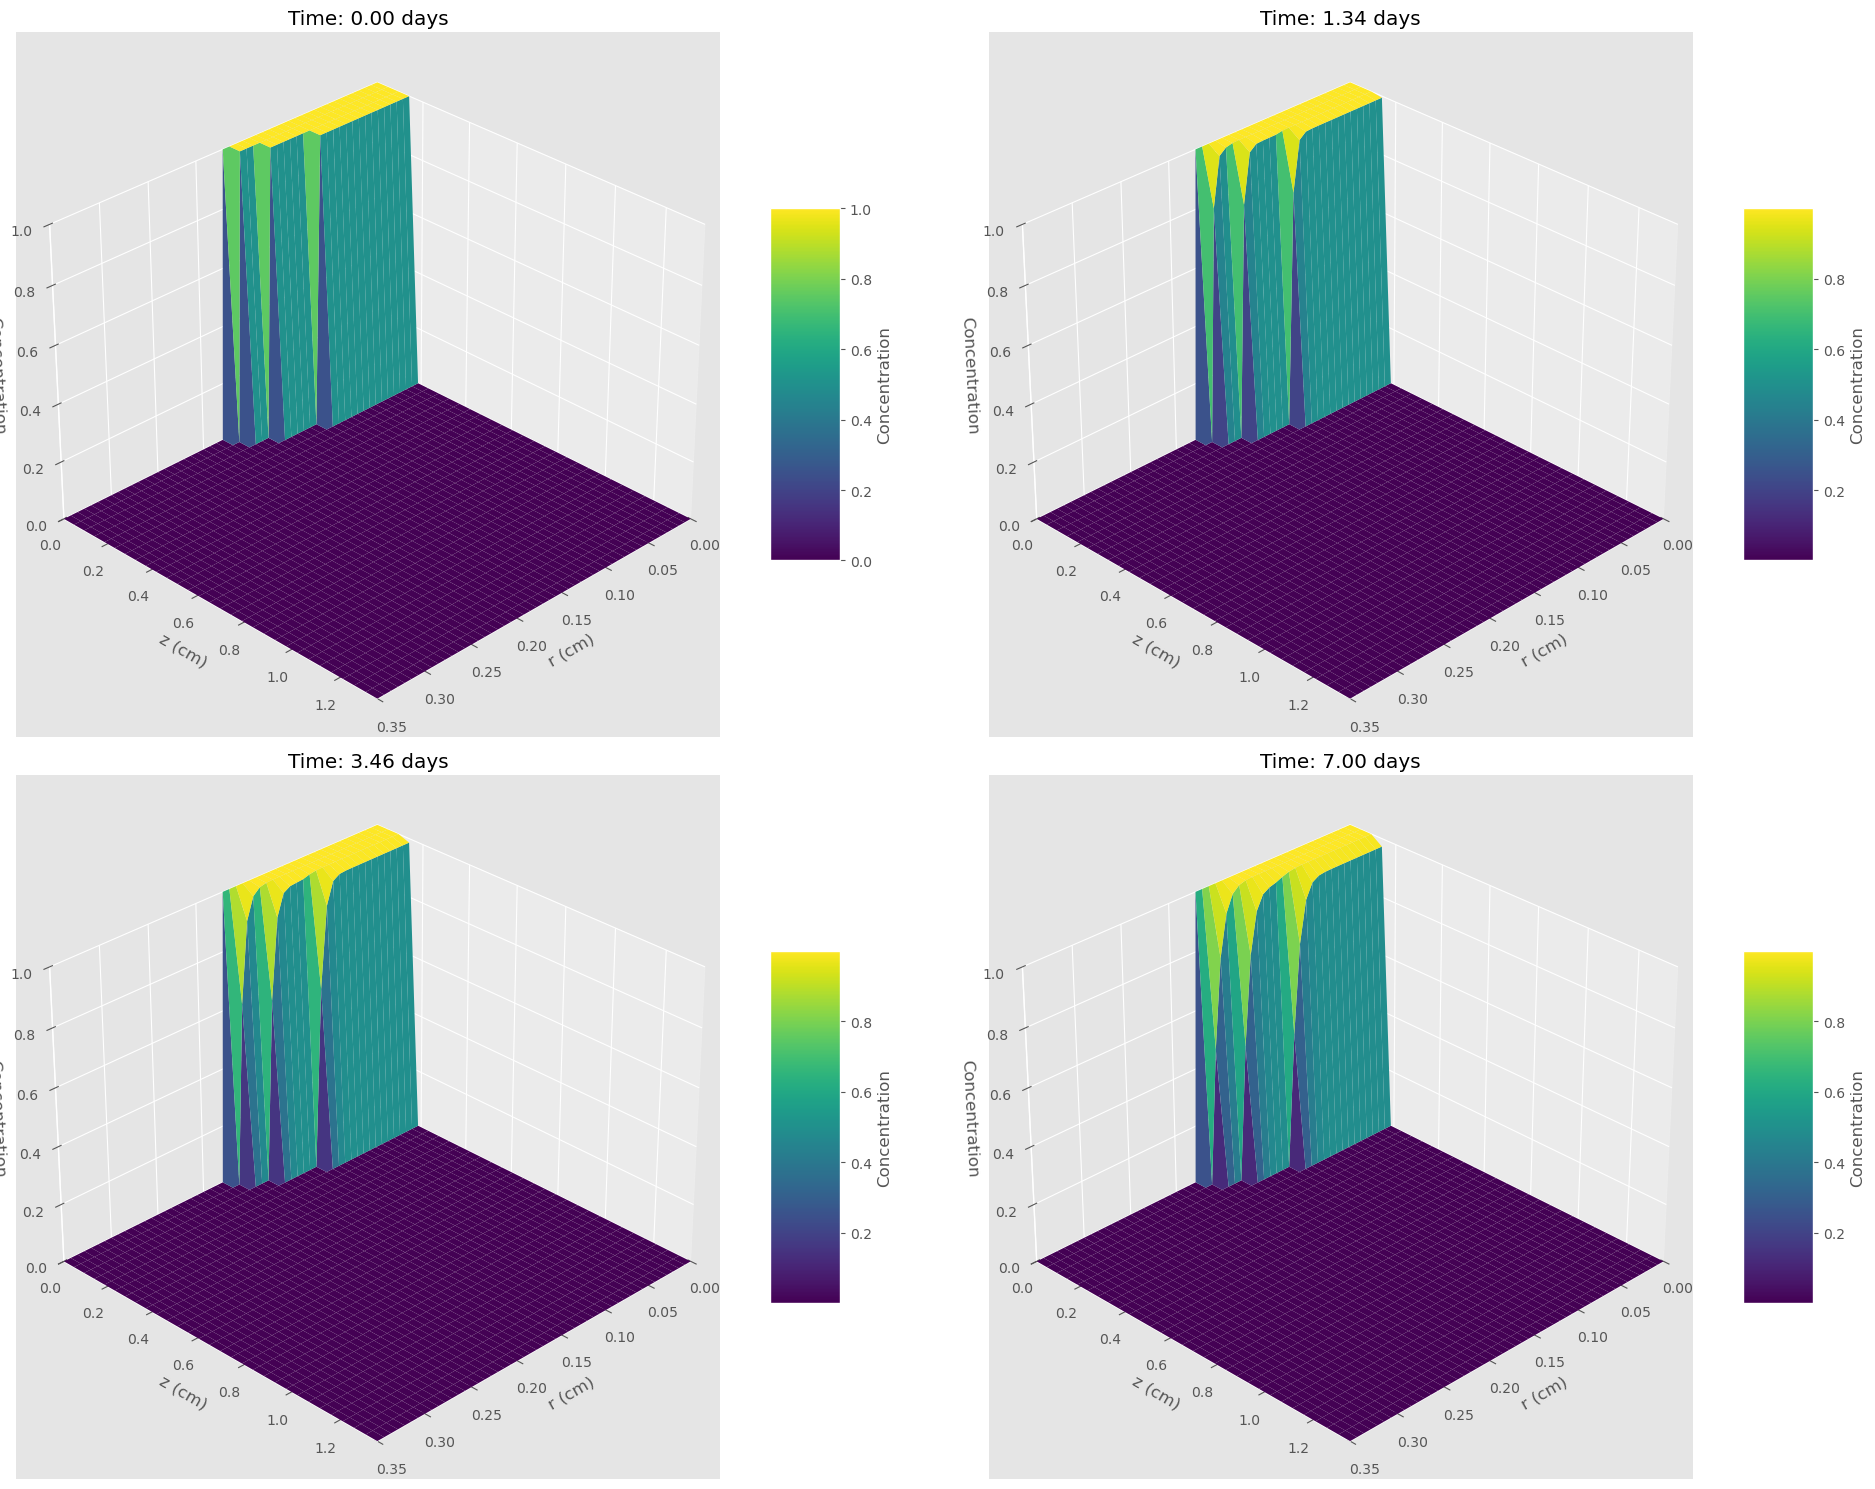

In [ ]:
# 2. 3D visualization of the concentration profile at different times
plt.figure(figsize=(20, 15))
times_for_3d = [0, 19, 49, 99]  # Different time points for 3D visualization

for i, idx in enumerate(times_for_3d):
    ax = plt.subplot(2, 2, i+1, projection='3d')
    
    # Display as a surface plot
    surf = ax.plot_surface(R, Z, C_history[idx], cmap='viridis', 
                         antialiased=True, rstride=1, cstride=1)
    
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Concentration')
    
    ax.set_xlabel('r (cm)')
    ax.set_ylabel('z (cm)')
    ax.set_zlabel('Concentration')
    ax.set_title(f"Time: {sample_time_days[idx]:.2f} days")
    ax.view_init(elev=30, azim=45)
    ax.set_xlim(0, radius*2)
    ax.set_ylim(0, 0.3)  # Adjusted to view up to 0.3 cm height
    ax.set_zlim(0, initial_concentration)

plt.tight_layout()
plt.show()

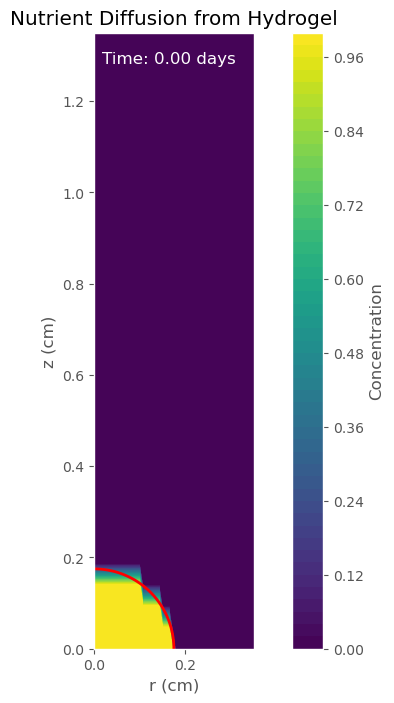

In [ ]:
# 3. Animation of concentration changes over time
def animate_diffusion(C_history, time_points):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Initial plot
    contour = ax.contourf(R, Z, C_history[0], levels=50, cmap='viridis')
    cbar = fig.colorbar(contour, label='Concentration')
    
    # Plot the hydrogel boundary
    theta = np.linspace(0, np.pi, 100)
    x_circle = radius * np.sin(theta)
    y_circle = radius * np.cos(theta)
    ax.plot(x_circle, y_circle, 'r-', linewidth=2)
    
    # Add straight line at z=height if height < radius
    if height < radius:
        ax.plot([-radius, radius], [height, height], 'r-', linewidth=2)
    
    time_text = ax.text(0.05, 0.95, f"Time: {time_points[0]/86400:.2f} days", 
                        transform=ax.transAxes, color='white', fontsize=12)
    
    ax.set_xlabel('r (cm)')
    ax.set_ylabel('z (cm)')
    ax.set_title('Nutrient Diffusion from Hydrogel')
    ax.set_xlim(0, radius*2)
    ax.set_ylim(0, 0.3)  # Adjusted to view up to 0.3 cm height
    ax.set_aspect('equal')
    
    def update(frame):
        ax.clear()
        contour = ax.contourf(R, Z, C_history[frame], levels=50, cmap='viridis')
        
        # Plot the hydrogel boundary again (since we cleared the axes)
        ax.plot(x_circle, y_circle, 'r-', linewidth=2)
        if height < radius:
            ax.plot([-radius, radius], [height, height], 'r-', linewidth=2)
        
        time_text = ax.text(0.05, 0.95, f"Time: {time_points[frame]/86400:.2f} days", 
                            transform=ax.transAxes, color='white', fontsize=12)
        
        ax.set_xlabel('r (cm)')
        ax.set_ylabel('z (cm)')
        ax.set_title('Nutrient Diffusion from Hydrogel')
        ax.set_xlim(0, radius*2)
        ax.set_ylim(0, 0.3)  # Adjusted to view up to 0.3 cm height
        ax.set_aspect('equal')
        
        return contour,
    
    # Create animation (use a subset of frames to keep it manageable)
    frames_to_use = np.linspace(0, len(C_history)-1, 50, dtype=int)
    anim = animation.FuncAnimation(fig, update, frames=frames_to_use, 
                                  interval=200, blit=False)
    
    return HTML(anim.to_jshtml())

# Generate the animation
animate_diffusion(C_history, time_points)

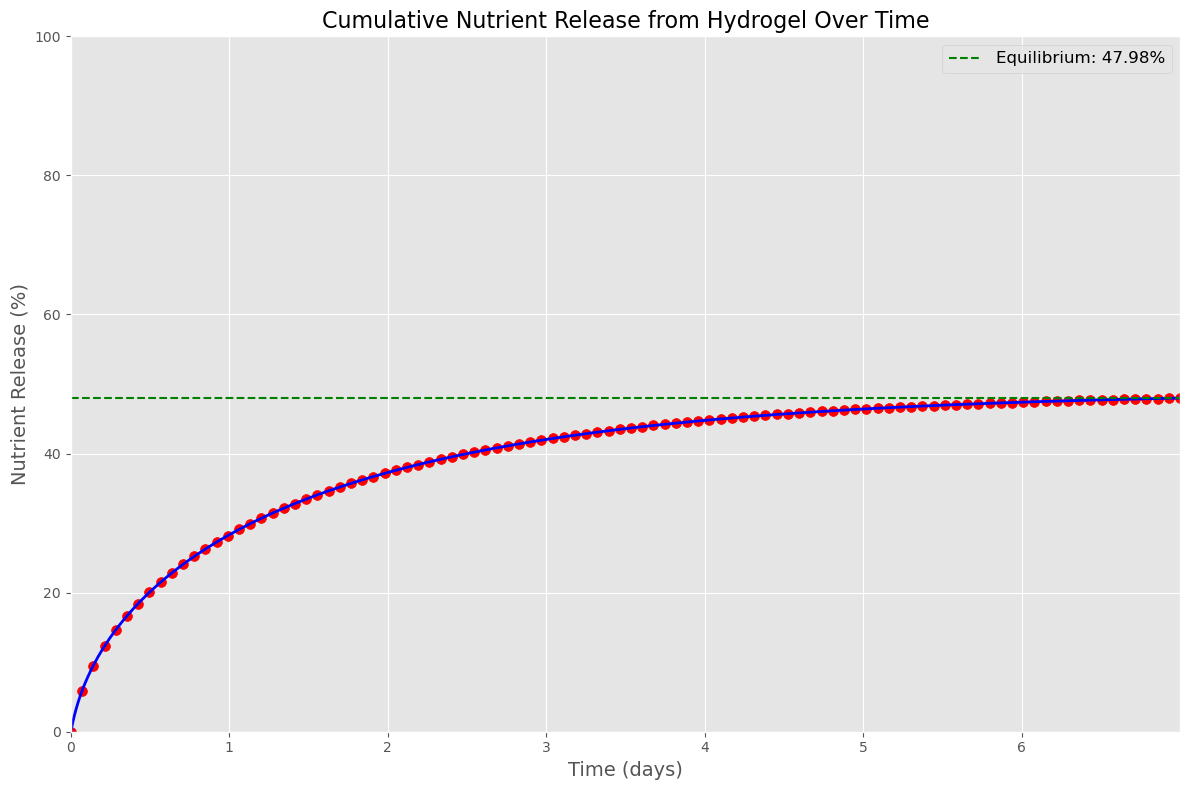

In [28]:
# 4. Plot cumulative nutrient release percentage versus time
plt.figure(figsize=(12, 8))

# Convert to days for plotting
time_days_full = np.array(all_time_points) / (24 * 3600)

plt.plot(time_days_full, all_release_percentages, '-', color='blue', linewidth=2)
plt.scatter(sample_time_days, release_percentage, color='red', s=50)

plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Nutrient Release (%)', fontsize=14)
plt.title('Cumulative Nutrient Release from Hydrogel Over Time', fontsize=16)
plt.grid(True)
plt.xlim(0, max(time_days_full))
plt.ylim(0, 100)

# Add a horizontal line at equilibrium release
final_release = all_release_percentages[-1]
plt.axhline(y=final_release, color='green', linestyle='--', 
           label=f'Equilibrium: {final_release:.2f}%')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()